In [1]:
import requests
import gzip
import pandas as pd
import networkx as nx
import numpy as np

%matplotlib inline
import seaborn as sns

import sys
sys.path = ['/cellar/users/mikeyu/DeepTranslate/ddot'] + sys.path

import ddot
from ddot import Ontology, get_gene_name_converter, parse_gaf, parse_obo, nx_to_NdexGraph, read_term_descriptions, ndex_to_sim_matrix
from ddot import expand_seed, melt_square, make_index, align_hierarchies, update_nx_with_alignment, parse_ndex_uuid

# Setup parameters

In [2]:
ndex_server = 'http://test.ndexbio.org'
ndex_user = 'mikeyu_testacct2'
ndex_pass = 'GoHejVeg8'

In [3]:
alpha = 0.1
beta = 0.5

In [4]:
seed = ['FANCA','FANCB', 'FANCC', 'BRCA2', 'FANCD2', 'FANCE',
        'FANCF', 'FANCG', 'FANCI', 'BRIP1', 'FANCL', 'FANCM', 'PALB2', 'RAD51C', 'SLX4', 'ERCC4', 'RAD51',
        'BRCA1', 'UBE2T', 'XRCC2']

In [5]:
similarity_uuid = 'd2dfa5cc-56de-11e7-a2e2-0660b7976219'

# Download similarity data from NDEx

In [6]:
# %time tmp = np.load('/cellar/users/mikeyu/DeepTranslate/hnexo/RFv2r3_square.npz')
# rf, rf_genes = tmp['rf'], tmp['genes']
# np.fill_diagonal(rf, 0)
# rf[np.isnan(rf)] = 0
# sim, sim_names = rf, rf_genes

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.45 ms


In [7]:
sim, sim_names = ndex_to_sim_matrix(
    similarity_uuid,
    ndex_server,
    ndex_user,
    ndex_pass,
    similarity='similarity',
    input_fmt='cx_matrix',
    output_fmt='matrix',
    subset=None)

# Expand known FA genes

min_sim: 5.20081410586


246

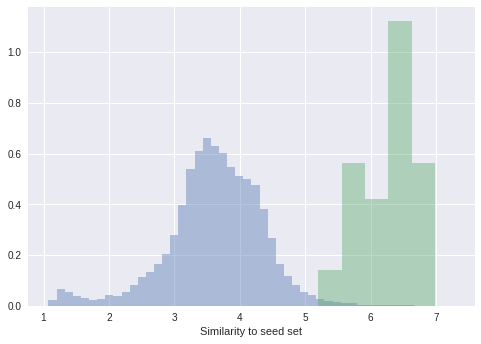

In [7]:
expand, expand_idx, sim_2_seed, fig = expand_seed(
    seed,
    sim,
    sim_names,
    agg='mean',
    min_sim=4,
    filter_perc=None,
    seed_perc=0,
    agg_perc=None,
    expand_size=None,
    figure=True,
)
expand = list(expand)
len(expand)

# Run CLIXO

In [8]:
df_sq = pd.DataFrame(sim[expand_idx, :][:, expand_idx], index=expand, columns=expand)
df = melt_square(df_sq)

In [9]:
ont = Ontology.run_clixo(df, alpha, beta)
# ont.propagate_annotations(direction='forward', inplace=True)

temp output: /tmp/tmplLgp7P
temp graph: /tmp/tmpYa736E
temp output log: /tmp/tmpQkCzxY
/tmp/tmpYa736E	0.1	0.5	-10000000 2017-08-10 02:59:52.916558
CLIXO command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/mhk7-clixo_0.3-cec3674/clixo /tmp/tmpYa736E 0.1 0.5 | awk '{if ( $1 ~ /^#/ ) {print "\#", strftime("%Y-%m-%d %H:%M:%S"), $0 ; fflush() } else {print $0}}' | tee /tmp/tmpQkCzxY
Extracting by grep -v # 2017-08-10 02:59:54.209748
Elapsed time (sec): 1.29730081558 2017-08-10 02:59:54.235148
Ontology: 246 genes, 38 terms, 290 gene-term relations, 38 term-term relations


In [10]:
# ont.to_3col_table('/cellar/users/mikeyu/tmp.txt')
# ont = Ontology.from_table('/cellar/users/mikeyu/tmp.txt')

# Align with Gene Ontology

## Read Gene Ontology from NDEx

In [11]:
go_human = Ontology.from_ndex(ddot.config.GO_HUMAN_URL)
go_human.summary()

'18765 genes, 19211 terms, 260093 gene-term relations, 43410 term-term relations'

In [12]:
# go_human = Ontology.from_table('/cellar/users/mikeyu/go.txt')

In [13]:
term_descriptions = read_term_descriptions('/cellar/users/mikeyu/DeepTranslate/go_human_7jun2017/goID_2_name.tab')
go_human.update_node_attr(term_descriptions.to_frame())

## Do alignment

In [14]:
alignment = ont.align(go_human, 3, 4, update_self=True, update_ref=True)
alignment.head()

collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpN0uldS
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpozcho5
Alignment command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/alignOntology/calculateFDRs /tmp/tmp2iIHDZ /tmp/tmpUt0FSD 0.05 criss_cross /tmp/tmpeppLdc 3 4 gene


,Term,Similarity,FDR
Term,,,
CLIXO:283,GO:0003674,0.982772,0.0
CLIXO:265,GO:0005662,0.892473,0.0
CLIXO:268,GO:0009378,0.879401,0.0
CLIXO:272,GO:0097472,0.516281,0.0
CLIXO:269,GO:0071140,0.459495,0.0


# Upload Ontology to NDEx
## To be viewed by Kei's Hierarchical Viewer

In [15]:
name = 'Fanconi Anemia Gene Ontology (FanGO)'
description = (
    'Data-driven ontology created by CLIXO '
    '(parameters: alpha={alpha}, beta={beta}). '
    'Created from similarity network '
    'at {ndex_server}/{ndex_uuid}').format(
        alpha=alpha,
        beta=beta,
        ndex_server=ndex_server,
        ndex_uuid=similarity_uuid)

ont_url, ont_ndexgraph = ont.to_ndex(
    name=name,
    description=description,
    term_2_uuid=True,
    sim=df,
    features=['similarity'],
    public=True
)

ont_url

# nx.write_graphml(ont_ndexgraph, '/cellar/users/mikeyu/tmp.graphml')

u'http://dev2.ndexbio.org/v2/network/c6116969-7db2-11e7-9743-0660b7976219'